# Topics as Map or Index

After loading the data, we are going to run the SciKit-Learn's NMF algorithm which is both fast for smaller corpora and deterministic in its outcomes varying the number of components until we seem to have achieved a stable number.

We are including both main and other TED-curated events here so that we can see how much the separate events are part of the larger map or if they are distinct.

As topic modelling has become more widespread, one of the issues increasingly being raised is right-sizing the number of components, since that is something that is principal variable given to the algorithm (be it LDA or NMF). The implementation that follows is based on the following:

* In an article in _Towards Data Science_, [Evaluate Topic Models: Latent Dirichlet Allocation][kapadia], Shashank Kapadia observes that most evaluations of enumerated topics are extrinsic in nature, a product of subject matter expertise and/or utility in performing a classification task. His approach is to implement an intrinsic evaluation using **gensim**'s `CoherenceModel`. He then fine tunes the hyperparameters. 
* The third notebook in Derek Greene's three-notebook tutorial on NMF focuses on [Parameter Selection][greene]. One of the hyperparameters involved has to do with initialization: Greene notes that "using SVD-based initialisation provides more reliable results." 

Greene's work is the foundation for the following exploration.

[kapadia]: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
[greene]: https://github.com/derekgreene/topic-model-tutorial/blob/master/3%20-%20Parameter%20Selection%20for%20NMF.ipynb

### Imports and Data

In [ ]:
# Imports, Functions, Stopwords
import numpy as np
import pandas as pd
import re
import gensim
import operator
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.style.use("ggplot")
mpl.rcParams.update({"font.size": 14})

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF
from itertools import combinations

# This library makes it easy to save "interim" results so that
# we don't have to get running algorithms over and over
from sklearn.externals import joblib



stopwords = set(stopwords.words('english'))

In [2]:
parentheticals = [ "\(laughter\)", "\(applause\)", "\(music\)", "\(video\)", 
                  "\(laughs\)", "\(applause ends\)", "\(audio\)", "\(singing\)", 
                  "\(music ends\)", "\(cheers\)", "\(cheering\)", "\(recording\)", 
                  "\(beatboxing\)", "\(audience\)", "\(guitar strum\)", 
                  "\(clicks metronome\)", "\(sighs\)", "\(guitar\)", "\(marimba sounds\)", 
                  "\(drum sounds\)" ]

def remove_parens(text):
    new_text = text
    for rgx_match in parentheticals:
        new_text = re.sub(rgx_match, ' ', new_text.lower(), flags=re.IGNORECASE)
    return new_text

In [3]:
# Load the Data
df = pd.read_csv('../output/TEDall.csv')

# Grab the text of the talks
talks = df.text.tolist()

# Create some labels we can use later but remove the redundant parts of the URL
labels = [re.sub('https://www.ted.com/talks/', '',item) for item in df.public_url.tolist()]

## TF-IDF

In [4]:
# Parametize the vectorizer:
tfidf_vectorizer = TfidfVectorizer(stop_words = stopwords,
                                   min_df = 2, 
                                   max_df = 0.9)

# Vectorize our texts
tfidf = tfidf_vectorizer.fit_transform(talks)
tfidf.shape 

(1747, 29197)

In [5]:
terms = tfidf_vectorizer.get_feature_names()
print(f"Vocabulary has {len(terms)} distinct terms.")

Vocabulary has 29197 distinct terms.


To see terms with the highest TF-IDF scores across all documents in the document-term matrix:

In [6]:
def rank_terms( A, terms ):
    # get the sums over each column
    sums = A.sum(axis=0)
    # map weights to the terms
    weights = {}
    for col, term in enumerate(terms):
        weights[term] = sums[0,col]
    # rank the terms by their weight over all documents
    return sorted(weights.items(), key=operator.itemgetter(1), reverse=True)

In [7]:
ranking = rank_terms( tfidf, terms )
for i, pair in enumerate( ranking[0:20] ):
    print(f"{i+1:2d} {pair[0]} ({pair[1]:.2f})")

 1 people (78.40)
 2 going (56.35)
 3 laughter (52.57)
 4 know (52.38)
 5 think (49.97)
 6 would (48.90)
 7 really (48.57)
 8 us (48.06)
 9 see (47.55)
10 world (47.42)
11 get (45.24)
12 time (44.11)
13 actually (40.92)
14 things (40.07)
15 years (38.63)
16 could (38.30)
17 way (37.82)
18 said (36.86)
19 go (36.71)
20 want (36.58)


In [45]:
joblib.dump((tfidf, terms, talks), "../output/tfidf.pkl")

['../output/tfidf.pkl']

To load this pickle:

```python
(tfidf, terms, talks) = joblib.load( "talks-tfidf.pkl" )
print( f"Loaded {tfidf.shape[0]} X {tfidf.shape[1]} document-term matrix.")
```

## K-Means Clustering based on TFIDF

In [9]:
kmeans = KMeans(
    init="random",
    n_clusters=25,
    n_init=10,
    max_iter=300,
    random_state=42
)

In [10]:
kmeans.fit(tfidf)
print(kmeans.inertia_, kmeans.n_iter_)

1554.20822846462 12


In [11]:
# Now let's try it for a range of possible clusters:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(25, 101, 10):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(tfidf)
    sse.append(kmeans.inertia_)

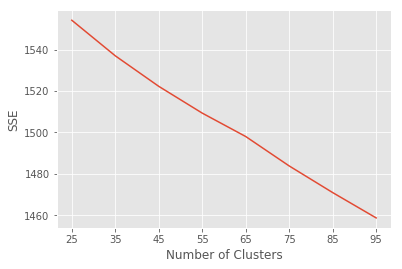

In [12]:
plt.style.use("ggplot")
plt.plot(range(25, 101, 10), sse)
plt.xticks(range(25, 101, 10))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

**Kmeans** doesn't turn up: the slight elbow at 45 doesn't show up when you run `Kneelocator`:

```python
from kneed import KneeLocator

kl = KneeLocator(range(25, 101, 10), sse, curve="convex", direction="decreasing")
print(kl.elbow)

UserWarning: No knee/elbow found
None
```

## Topic Coherence (via Word2Vec)

In [51]:
from nltk import word_tokenize
from nltk import sent_tokenize
import gensim
import operator

### 1. Create the Topic Models

In [46]:
kmin, kmax = 20, 80

topic_models = []
# try each value of k
for k in range(kmin, kmax + 1, 10):
    print( f"Applying NMF for k={k}" )
    # run NMF
    model = NMF( init="nndsvd", n_components=k ) 
    W = model.fit_transform( tfidf )
    H = model.components_    
    # store for later
    topic_models.append( (k,W,H) )

Applying NMF for k=20 ...
Applying NMF for k=30 ...
Applying NMF for k=40 ...
Applying NMF for k=50 ...
Applying NMF for k=60 ...
Applying NMF for k=70 ...
Applying NMF for k=80 ...


### 2. Build the Word Embedding Models

The topic coherence measure called TC-W2V relies on the use of a word embedding model constructed from the same corpus as the topic model. Here we use the Gensim implementation to build a Word2Vec model based on the TED talk texts.

Because individual texts do not matter for `word2vec`, we are going to bundle all our sentences into a single string, then break it into sentences using the NLTK sentence tokenizer. We preprocess the sentences to make them lowercase and to remove stop words. 

Two implementations of Word2Vec are below: the first is the standard version and the second is a FastText version that makes it possible to locate words not in a vocabulary/model. 

In [68]:
def sentencer(sentence):
    global stopwords
    tokens = word_tokenize(sentence)
    sentenced = [token for token in tokens if token not in stopwords] # and  len(token)>2
    return sentenced

In [69]:
all_talks = ' '.join(talks).lower()

In [70]:
raw = sent_tokenize(all_talks)
# Check our work by getting the number of sentences and three sentences
print(len(raw), raw[500:503])

220118 ['antiquated zoning and land-use regulations are still used to this day to continue putting polluting facilities in my neighborhood.', 'are these factors taken into consideration when land-use policy is decided?', 'what costs are associated with these decisions?']


In [71]:
sentences = [sentencer(sentence) for sentence in raw]
print(len(sentences), sentences[500:503])

220118 [['antiquated', 'zoning', 'land-use', 'regulations', 'still', 'used', 'day', 'continue', 'putting', 'polluting', 'facilities', 'neighborhood', '.'], ['factors', 'taken', 'consideration', 'land-use', 'policy', 'decided', '?'], ['costs', 'associated', 'decisions', '?']]


#### 2a. Word2Vec

In [72]:
# the model has 500 dimensions, the minimum document-term frequency is 10
w2v_model = gensim.models.Word2Vec(sentences, size=500, min_count=10, sg=1)

In [73]:
print( f"Model has {len(w2v_model.wv.vocab)} terms." )

Model has 13050 terms.


In [74]:
w2v_model.wv.most_similar(positive=["climate"])

[('warming', 0.7443718910217285),
 ('urbanization', 0.7052319049835205),
 ('impacts', 0.6816669702529907),
 ('biodiversity', 0.677349328994751),
 ('negotiations', 0.6746939420700073),
 ('two-degree', 0.655472993850708),
 ('desertification', 0.6529867649078369),
 ('deforestation', 0.6514017581939697),
 ('degradation', 0.6441167593002319),
 ('threat', 0.6440238952636719)]

In [75]:
w2v_model.wv.most_similar(['good'])

[('bad', 0.7264183759689331),
 ('excellent', 0.624242901802063),
 ('chariot', 0.5855712890625),
 ('hopeless', 0.5562121868133545),
 ('stressful', 0.5558778643608093),
 ('carbs', 0.5423855781555176),
 ('timing', 0.541711688041687),
 ('depressing', 0.5413867831230164),
 ('stupid', 0.5392094850540161),
 ('lousy', 0.5367733240127563)]

In [59]:
# Save for later
# w2v_model.save("../output/w2v-model-500-10.bin")

In [60]:
# To re-load this model, run
# w2v_model = gensim.models.Word2Vec.load("w2v-model.bin")

#### 2b. FastText

After encountering repeated **`KeyErrors`** for words "not in vocabulary" we are trying the `FastText` model which promises to handle out-of-vocabulary words.

In [82]:
# Alternate to to obtain word vectors for out-of-vocabulary words
ft = gensim.models.FastText(sentences, size=500, min_count=10, sg=1)

In [83]:
print( f"FastText model has {len(ft.wv.vocab)} terms." )

FastText model has 13050 terms.


### 3. Select the Number of Topics

In [61]:
from itertools import combinations

In [85]:
def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            pair_scores.append( w2v_model.wv.similarity(pair[0], pair[1]) )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

**2020-09-07**: I'm working on the `KeyError: "word not in vocabulary"` error.

In [86]:
k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 10 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( ft, term_rankings ) )
    print(f"K={k}: Coherence={coherences[-1]:.4f}")

K=20: Coherence=0.4817
K=30: Coherence=0.4962
K=40: Coherence=0.5021
K=50: Coherence=0.5062
K=60: Coherence=0.5054
K=70: Coherence=0.5042
K=80: Coherence=0.4993


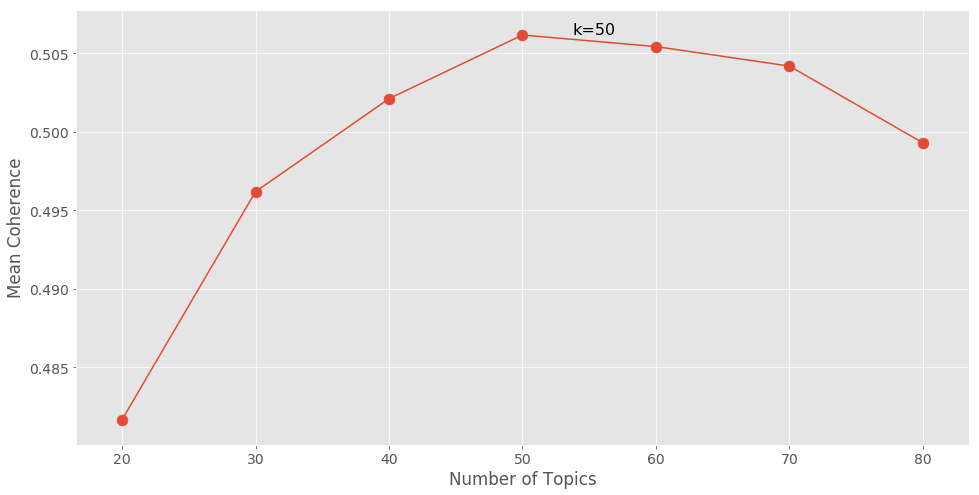

In [88]:
fig = plt.figure(figsize=(16,8))
# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter( k_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate(f"k={best_k}", 
             xy=(best_k, ymax), 
             xytext=(best_k, ymax), 
             textcoords="offset points", 
             fontsize=16)
# show the plot
plt.show()